In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os, sys
import functools

os.chdir('..')
sys.path.append('..')
from data import dataset
from models import burn_in_lstm
print('OK!')

OK!


In [24]:
INPUT_SHAPE_SPEC = (
    tf.TensorSpec([None, 14, 20], tf.float32),
    tf.TensorSpec([None, 19], tf.float32),
    tf.TensorSpec([None, 3], tf.int32)
)

class SimpleSequentialLSTM_SavedModel(burn_in_lstm.SimpleSequentialLSTM):
    def __init__(self):
        super(SimpleSequentialLSTM_SavedModel, self).__init__()
    
    @tf.function(input_signature=[INPUT_SHAPE_SPEC])
    def call(self, input_ops):
        input_seq, input_basic_num, input_basic_cat = input_ops

        # processing sequential features
        seq_list = tf.unstack(input_seq, axis=1)
        seq_embedding = tf.stack([self.shared_dense(seq) for seq in seq_list], axis=1)
        lstm_output, state_h, state_c = self.lstm(seq_embedding)
        
        # processing basic features
        industry, area, codenum = tf.unstack(input_basic_cat, axis=-1)
        industry_embedded = self.industry_embedding(industry)
        area_embedded = self.area_embedding(area)
        codenum_embedded = self.code_embedding(codenum)

        basic_features = tf.concat([
            input_basic_num, industry_embedded, area_embedded, codenum_embedded
        ], axis=-1)
        basic_embedding = self.basic_dense(basic_features)

        # processing global features
        global_features = tf.concat([state_h, basic_embedding], axis=-1)
        logits = self.global_dense(global_features)
        return logits
    

ds_train, ds_test = dataset.build_tfrecord_dataset('/home/yuki/Documents/ymx/stock_research/data/records', 1, 1)

In [27]:
def load_model():
    model = burn_in_lstm.SimpleSequentialLSTM()
#     model = burn_in_lstm.BurnInStateLSTM()
#     model = SimpleSequentialLSTM_SavedModel()
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    adam = tf.keras.optimizers.Adam(lr=1e-3)
    metrics = [
        tf.keras.metrics.BinaryAccuracy(name='acc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    model.compile(loss=loss, optimizer=adam, metrics=metrics)
    #model.build(input_shape=[(None, 14, 20), (None, 19), (None, 3)])
    xs, ys = next(iter(ds_train))
    model.call(xs)

    model_basedir = '/home/yuki/Documents/ymx/stock_research/train'
    if 'basic_lstm.v2.01.hdf5' in os.listdir(model_basedir):
        model.load_weights(os.path.join(model_basedir, 'basic_lstm.v2.01.hdf5'))
        print(' [*] Loaded pretrained model basic_lstm.v2.01.hdf5')
    return model

model = load_model()

 [*] Loaded pretrained model basic_lstm.v2.01.hdf5


## Compute KNN similarity matrices

In [9]:
import pprint

stock_basics = pd.read_csv('./data/stock_basics.csv')

def get_codenum_representation():
    value_set = list(set(stock_basics['codenum'].values.tolist()))
    value_set = list(map(lambda x: str(x).zfill(6), value_set))
    value_hash = dict(zip(value_set, list(range(len(value_set)))))
    return value_hash

stock_code_hash = get_codenum_representation()
stock_code_hash_reversed = dict(zip(stock_code_hash.values(), stock_code_hash.keys()))
# pprint.pprint(stock_code_hash)
print('OK')

OK


In [17]:
import heapq

def from_code_to_name(codestr):
    codenum = stock_code_hash_reversed[int(codestr)]
    dfline = stock_basics[stock_basics['codenum'] == int(codenum)]
    assert len(dfline) == 1, f'codestr={codestr} len(dfline)={len(dfline)}'
    return dfline['name'].values[0]

def get_knn_mapping(k=7):
    heapdict = {key: [] for key in stock_code_hash.keys()}
    niter = 0
    for x, xcode in stock_code_hash.items():
        ycodes = list(stock_code_hash.values()).copy()
        ycodes.remove(stock_code_hash[x])
        xcodes_arr = np.array([xcode] * len(ycodes), dtype=np.int32)
        ycodes_arr = np.array(ycodes, dtype=np.int32)
        simarray = model.stock_cosine_similarity(xcodes_arr, ycodes_arr)
        topk = tf.argsort(simarray, direction='DESCENDING')[: k]
        topk = topk.numpy().tolist()
        for elem in topk:
            heapdict[x].append(from_code_to_name(ycodes[elem]))
        if niter % 100 == 1:
            print('\r', f'>>>>>>>>>> iter={niter}', end='')
        niter += 1
    print('')
    return heapdict


stock_knn_mapping = get_knn_mapping()
print(stock_knn_mapping['600000'])

 >>>>>>>>>> iter=3801
['国海证券', '东北证券', '永太科技', '国光电器', '吉药控股', '安阳钢铁', '鹏欣资源']


## Stock selection statistics

- The distribution of predicted probabilities over a given threshold
- The histogram of industry

In [1]:
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np

datafile = '/home/yuki/Documents/ymx/stock_research/docs/stock_selection.md'
with open(datafile, 'r') as fd:
    lines = fd.readlines()[10: ]
statdict = {
    'industry': [],
    'prob': []
}
for ln in lines:
    contents = ln[: -1].split(' | ')
    statdict['industry'].append(contents[3])
    statdict['prob'].append(float(contents[-1][1: -1]))
print(f'len(statdict)={len(statdict)}, len(industry)={len(statdict["industry"])}')

len(statdict)=2, len(industry)=240


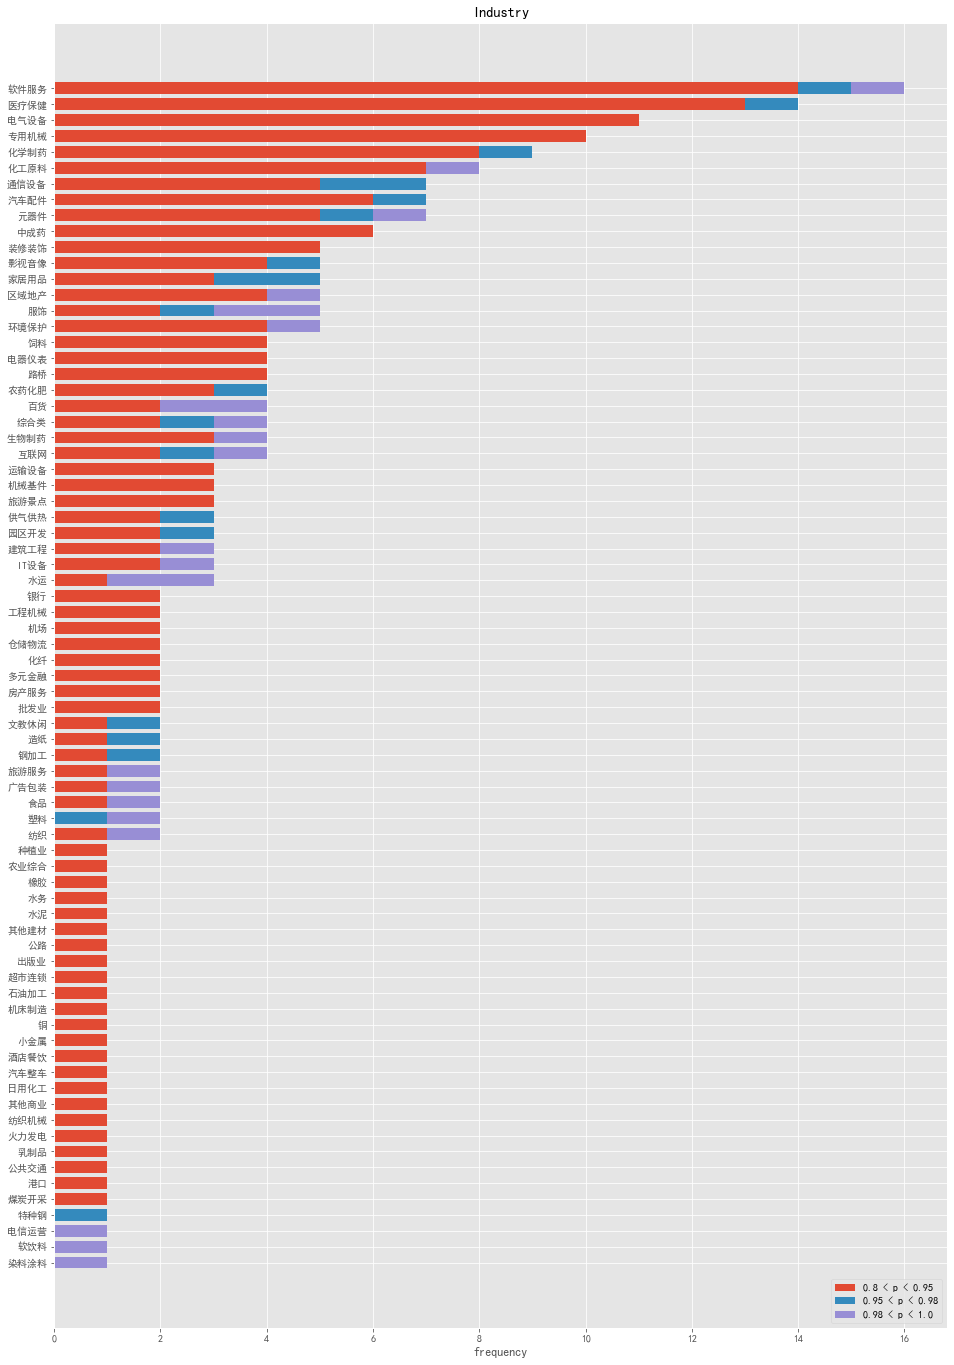

In [2]:
def gen_stats(sdata):
    res = OrderedDict()
    for prob, ind in zip(sdata['prob'], sdata['industry']):
        if ind not in res.keys():
            # [total_num, small, middle, large]
            res[ind] = [0, 0, 0, 0]
        res[ind][0] += 1
        if prob < 0.95:
            res[ind][1] += 1
        elif prob > 0.95 and prob < 0.98:
            res[ind][2] += 1
        else:
            res[ind][3] += 1
    res_sorted = sorted(list(res.items()), key=lambda x: x[1][0])
    tick_values = [item[1] for item in res_sorted]
    tick_labels = [item[0] for item in res_sorted]
    return tick_labels, tick_values


tick_labels, tick_values = gen_stats(statdict)
small_segment = [val[1] for val in tick_values]
middle_segment = [val[2] for val in tick_values]
small_middle = [x + y for x, y in zip(small_segment, middle_segment)]
large_segment = [val[3] for val in tick_values]

plt.close()
plt.style.use('ggplot')
# wrong output with chinese characters as tick_label
# solution from https://www.zhihu.com/question/25404709
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(16, 24))
plt.barh(tick_labels, small_segment,height=0.75)
plt.barh(tick_labels, middle_segment, height=0.75, left=small_segment)
plt.barh(tick_labels, large_segment, height=0.75, left=small_middle)
plt.legend(['0.8 < p < 0.95', '0.95 < p < 0.98', '0.98 < p < 1.0'], loc='lower right')
plt.xlabel('frequency')
plt.title('Industry')
plt.savefig('/home/yuki/Documents/ymx/stock_research/docs/images/stock_selection_stats.png', format='png', dpi=200)
plt.show()